In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv(r"C:\Users\User\Desktop\test\Anomaly_bank_transactions_data_2 - Anomaly_bank_transactions_data_2.csv")

In [3]:
print("Shape of the dataset:", df.shape)
# display(df.head())
print("\nDataset Information:")
print(df.info())
print("\nStatistical Summary:")
display(df.describe().T)

Shape of the dataset: (2512, 16)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts          

,count,mean,std,min,25%,50%,75%,max
TransactionAmount,2512.0,297.593778,291.946243,0.26,81.885,211.14,414.5275,1919.11
CustomerAge,2512.0,44.673965,17.792198,18.00,27.000,45.00,59.0000,80.00
TransactionDuration,2512.0,119.643312,69.963757,10.00,63.000,112.50,161.0000,300.00
LoginAttempts,2512.0,1.124602,0.602662,1.00,1.000,1.00,1.0000,5.00
AccountBalance,2512.0,5114.302966,3900.942499,101.25,1504.370,4735.51,7678.8200,14977.99


In [5]:
print(f'\nMissing values: {df.isna().sum().sum()}')
print(f'Duplicated values: {df.duplicated().sum()}')            #dup entire row


Missing values: 0
Duplicated values: 0


In [6]:
print("\nUnique Values in Each Column:")
print(df.nunique())


Unique Values in Each Column:
TransactionID              2512
AccountID                   495
TransactionAmount          2455
TransactionDate            2512
TransactionType               2
Location                     43
DeviceID                    681
IP Address                  592
MerchantID                  100
Channel                       3
CustomerAge                  63
CustomerOccupation            4
TransactionDuration         288
LoginAttempts                 5
AccountBalance             2510
PreviousTransactionDate     360
dtype: int64


In [7]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [8]:
num_cols

['TransactionAmount',
 'CustomerAge',
 'TransactionDuration',
 'LoginAttempts',
 'AccountBalance']

EDA

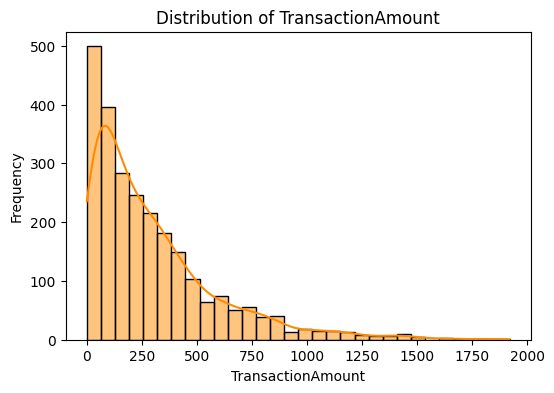

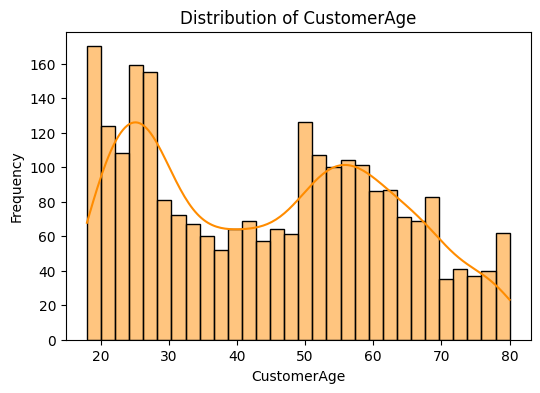

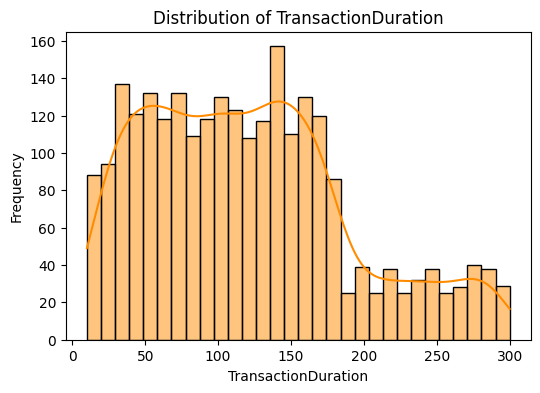

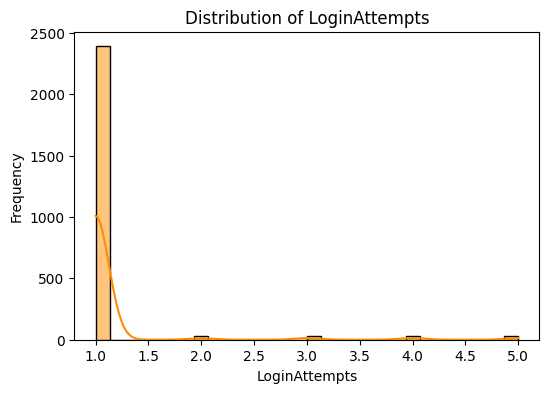

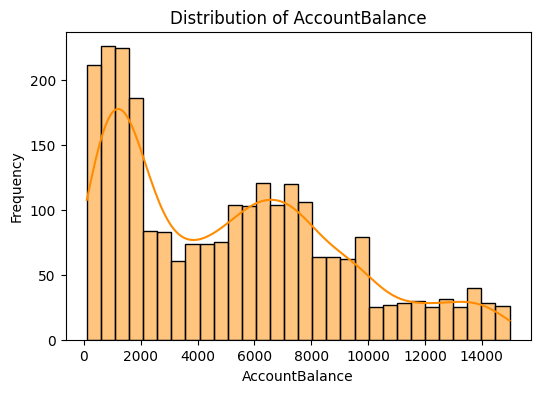

In [ ]:
def plot_histograms(df, num_cols):
    for column in num_cols:
        plt.figure(figsize=(6, 4))
        # Create a histogram with KDE
        # plt.hist(df[column],bins=30)
        sns.histplot(df[column], bins=30, kde=True, color='#ff8c00')                      #kde = trend line
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

plot_histograms(df, num_cols)

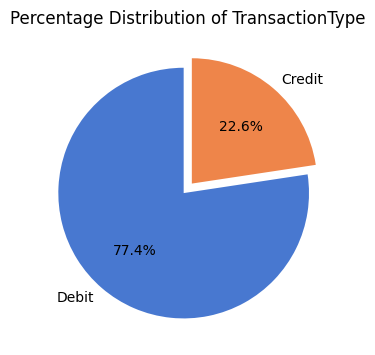

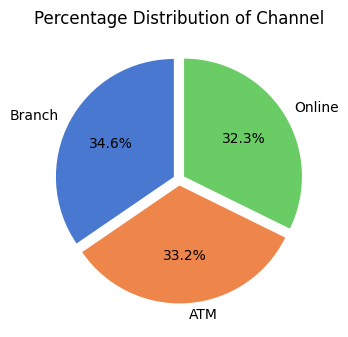

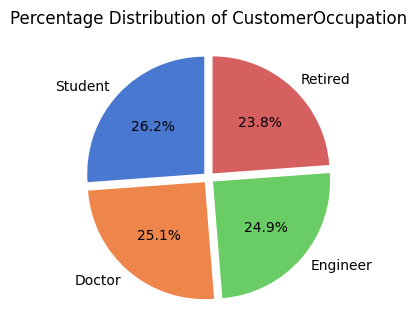

In [28]:
def plot_cat(columns,data=df,palette='muted'):
    # plt.figure(figsize=(10,10))
    for i,column_name in enumerate(columns):
        plt.figure(figsize=(10,10))
        plt.subplot(1, 3, i+1)
        value_counts=data[column_name].value_counts()
        value_counts.plot.pie(autopct='%1.1f%%',colors = sns.color_palette(palette),
                              startangle = 90, explode = [0.05] * value_counts.nunique())
        plt.title(f'Percentage Distribution of {column_name}')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()

columns_to_plot = ['TransactionType', 'Channel', 'CustomerOccupation']
plot_cat(columns_to_plot)

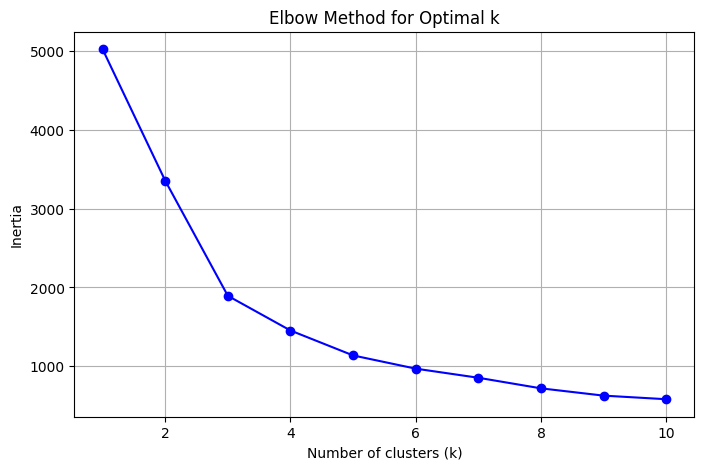

In [36]:
features = ['TransactionAmount','TransactionDuration']
x = df[features].copy()
scaler = StandardScaler()
x_sc = scaler.fit_transform(x)

#choose optimal K - Elbow method

inertia = []
K = range(1,11)             #1-10
for k in K:
    km = KMeans(n_clusters = k, random_state=0)
    km.fit(x_sc)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

#choose k = 3 at elbow point


In [37]:
km = KMeans(n_clusters=3, random_state=0)
km.fit(x_sc)

KMeans(n_clusters=3, random_state=0)

In [38]:
df['Cluster'] = km.labels_
df['DistanceToCentroid'] = np.linalg.norm(x_sc-km.cluster_centers_[km.labels_],axis=1)

threshold =df['DistanceToCentroid'].quantile(0.95)              # > 95% fraud
potential_frauds = df[df['DistanceToCentroid']>threshold]

print(f"Number of potential frauds detected: {len(potential_frauds)}")
display(potential_frauds)

Number of potential frauds detected: 126


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,Cluster,DistanceToCentroid
74,TX000075,AC00265,1212.51,2023-10-04 16:36:29,Debit,Indianapolis,D000231,193.83.0.183,M036,Branch,20,Student,24,1,605.95,2024-11-04 8:06:51,0,1.876727
85,TX000086,AC00098,1340.19,2023-09-29 17:22:10,Credit,Austin,D000574,165.114.224.47,M012,Online,54,Engineer,30,1,8654.28,2024-11-04 8:06:53,0,2.163279
141,TX000142,AC00114,1049.92,2023-10-23 16:50:33,Debit,Detroit,D000522,121.67.144.20,M052,ATM,80,Retired,21,1,2037.85,2024-11-04 8:10:34,0,1.562140
142,TX000143,AC00163,227.14,2023-07-03 17:42:08,Debit,Charlotte,D000439,197.162.55.147,M057,ATM,18,Student,294,1,341.94,2024-11-04 8:11:34,2,1.521390
146,TX000147,AC00385,973.39,2023-08-30 17:23:20,Debit,Sacramento,D000292,202.194.199.70,M026,Branch,77,Retired,296,1,2042.22,2024-11-04 8:11:44,0,2.640557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,TX002404,AC00111,1493.00,2023-06-07 17:05:41,Debit,Colorado Springs,D000344,136.162.111.135,M096,ATM,69,Retired,151,1,1619.16,2024-11-04 8:07:07,0,2.368753
2414,TX002415,AC00028,1664.33,2023-09-25 17:11:19,Debit,San Antonio,D000072,116.106.207.139,M064,Branch,18,Student,65,1,1588.31,2024-11-04 8:07:07,0,2.986511
2439,TX002440,AC00439,538.17,2023-09-26 17:27:17,Credit,Washington,D000430,116.44.12.250,M055,Branch,27,Engineer,252,1,5908.04,2024-11-04 8:10:25,2,1.490003
2445,TX002446,AC00439,403.01,2023-09-04 17:32:35,Debit,Washington,D000677,223.32.70.156,M029,Online,63,Doctor,286,3,10513.52,2024-11-04 8:09:32,2,1.573122


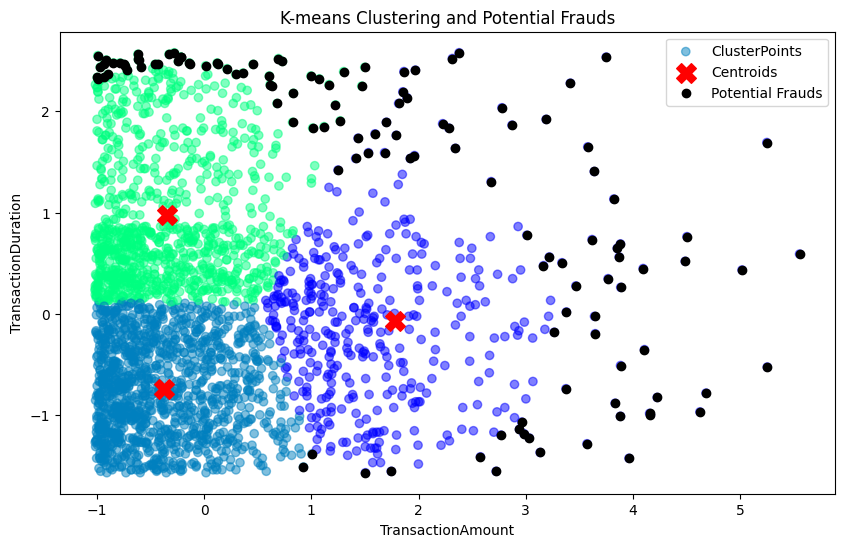

In [50]:
plt.figure(figsize=(10, 6))
# Plot clusters
scatter = plt.scatter(x_sc[:, 0], x_sc[:, 1], c=km.labels_, cmap='winter', alpha=0.5, label='ClusterPoints')
# Plot cluster centroids
centroids = plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=200, c='red', marker='X',label='Centroids')
# Plot potential frauds
frauds = plt.scatter(x_sc[potential_frauds.index, 0], x_sc[potential_frauds.index, 1], c='black',label='Potential Frauds', edgecolors='k')


plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('K-means Clustering and Potential Frauds')
plt.legend(loc='upper right')
plt.show()